In [ ]:
%run eda.ipynb

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

KMeans-Clustering

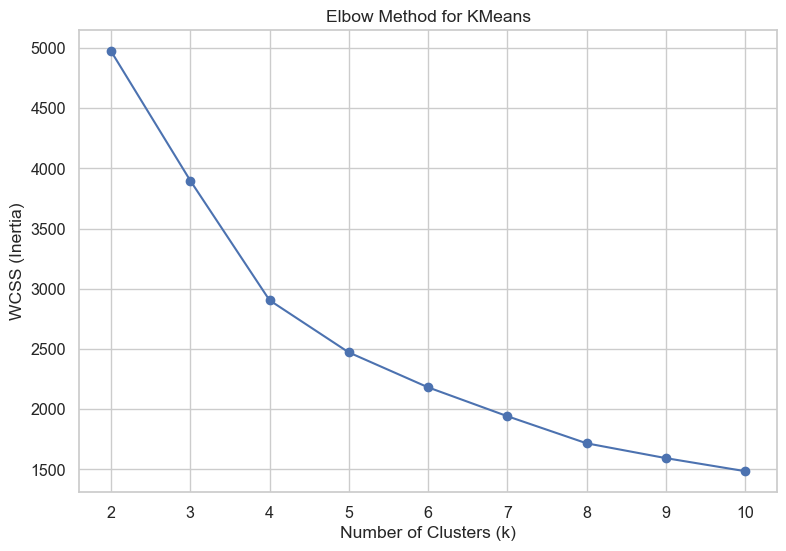

In [3]:
# Elbow Method
inertias = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(rfm_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.show()

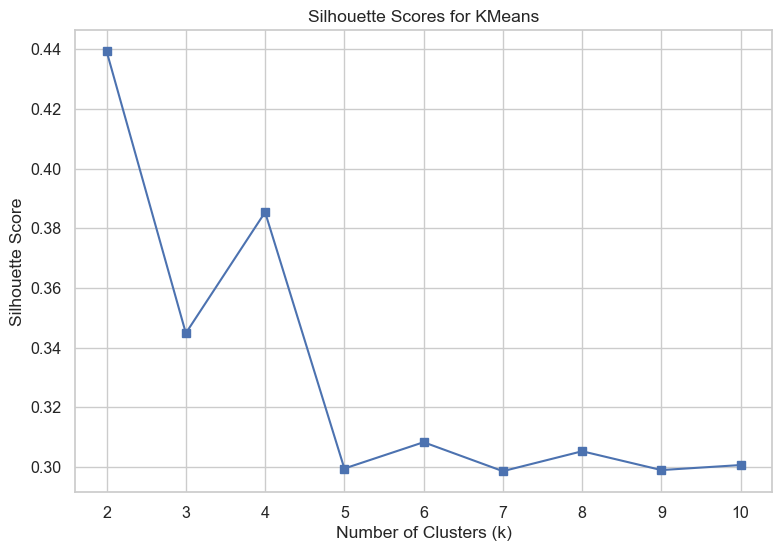

In [4]:
# Silhouette Method
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

plt.plot(K_range, sil_scores, marker='s')
plt.title("Silhouette Scores for KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [6]:
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

optimal_k = K_range[np.argmax(sil_scores)]
print(f" Best K for KMeans: {optimal_k}, Silhouette Score: {max(sil_scores):.4f}")

 Best K for KMeans: 2, Silhouette Score: 0.4393


In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
rfm["KMeans_Cluster"] = kmeans.fit_predict(rfm_scaled)

Hierarchical Clustering

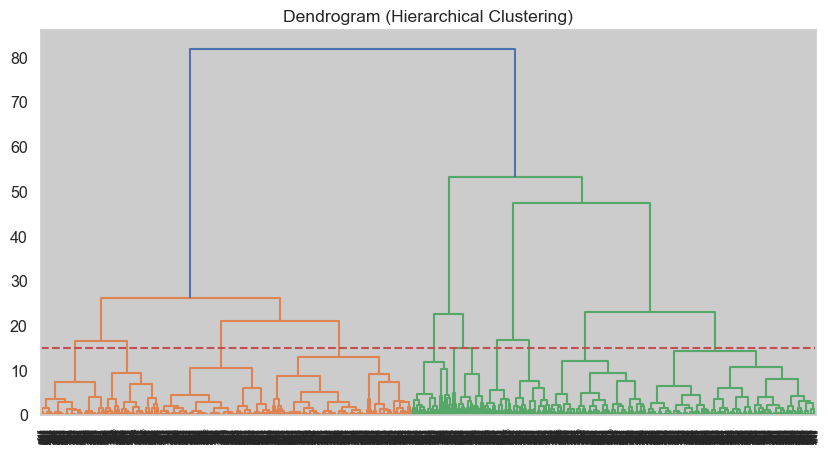

In [9]:
import scipy.cluster.hierarchy as sch

# Dendrogram
plt.figure(figsize=(10,5))
dend = sch.dendrogram(sch.linkage(rfm_scaled, method="ward"))
plt.axhline(y=15, color='r', linestyle='--')  # example cut
plt.title("Dendrogram (Hierarchical Clustering)")
plt.show()

In [17]:
# Silhouette Comparison
best_score, best_params = -1, None
for linkage in ["ward", "average", "complete"]:
    for k in range(2, 8):
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(rfm_scaled)
        score = silhouette_score(rfm_scaled, labels)
        if score > best_score:
            best_score, best_params = score, (linkage, k)

print(f"Best Hierarchical: linkage={best_params[0]}, k={best_params[1]} (Silhouette={best_score:.3f})")


Best Hierarchical: linkage=average, k=2 (Silhouette=0.592)


In [18]:
agglo = AgglomerativeClustering(n_clusters=best_params[1], linkage=best_params[0])
rfm["Hier_Cluster"] = agglo.fit_predict(rfm_scaled)

DBSCAN Parameter Tuning

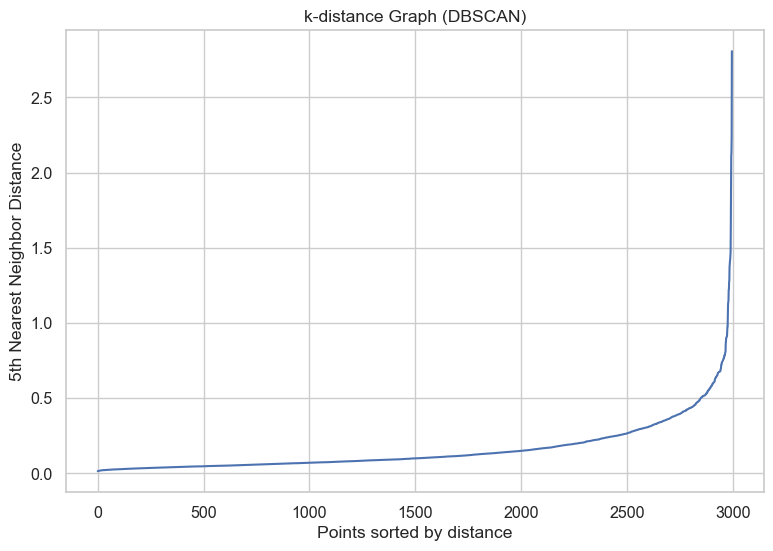

In [19]:
# k-distance graph
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)
distances = np.sort(distances[:, 5])

plt.plot(distances)
plt.title("k-distance Graph (DBSCAN)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.show()

In [20]:
best_db_score, best_db_params = -1, None
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_s in [4, 6, 8]:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(rfm_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(rfm_scaled, labels)
            if score > best_db_score:
                best_db_score, best_db_params = score, (eps, min_s)

print(f" Best DBSCAN: eps={best_db_params[0]}, min_samples={best_db_params[1]} (Silhouette={best_db_score:.3f})")


 Best DBSCAN: eps=0.5, min_samples=8 (Silhouette=0.225)


In [21]:
dbscan = DBSCAN(eps=best_db_params[0], min_samples=best_db_params[1])
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

Cluster Comparison

In [22]:
print("\n Final Cluster Results:")
print("KMeans:", silhouette_score(rfm_scaled, rfm["KMeans_Cluster"]))
print("Hierarchical:", silhouette_score(rfm_scaled, rfm["Hier_Cluster"]))
print("DBSCAN:", silhouette_score(rfm_scaled, rfm["DBSCAN_Cluster"]))


 Final Cluster Results:
KMeans: 0.4393153981372435
Hierarchical: 0.5918036806487699
DBSCAN: 0.22544922494393696


Cluster 0  → Loyal & High-Value Customers.

Cluster 1  → Churned or Low-Value Customers.

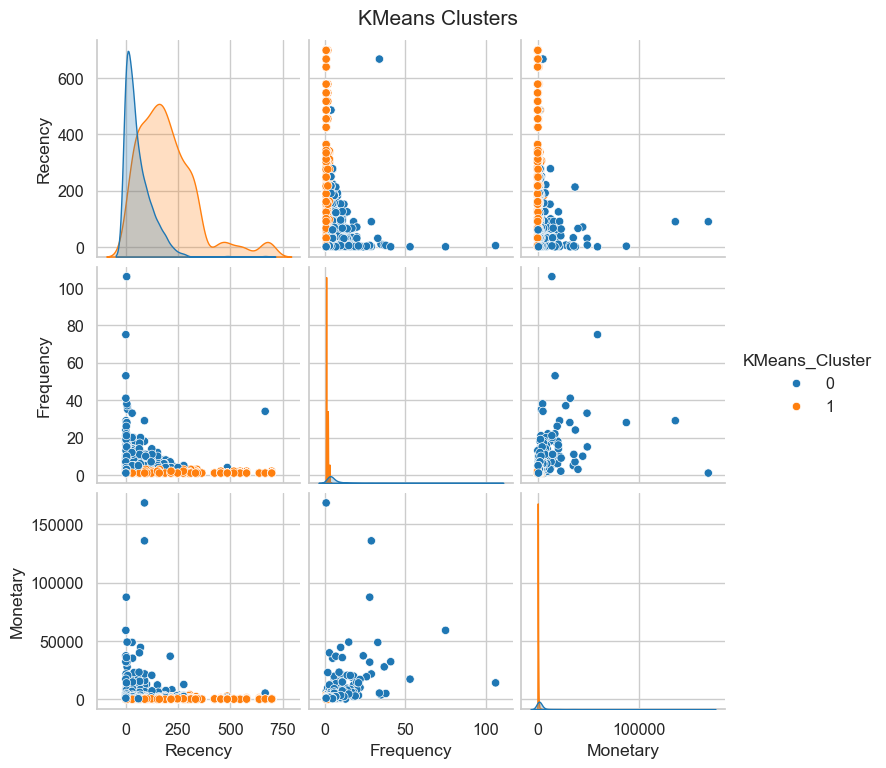

In [23]:
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="KMeans_Cluster", palette="tab10")
plt.suptitle("KMeans Clusters", y=1.02)
plt.show()

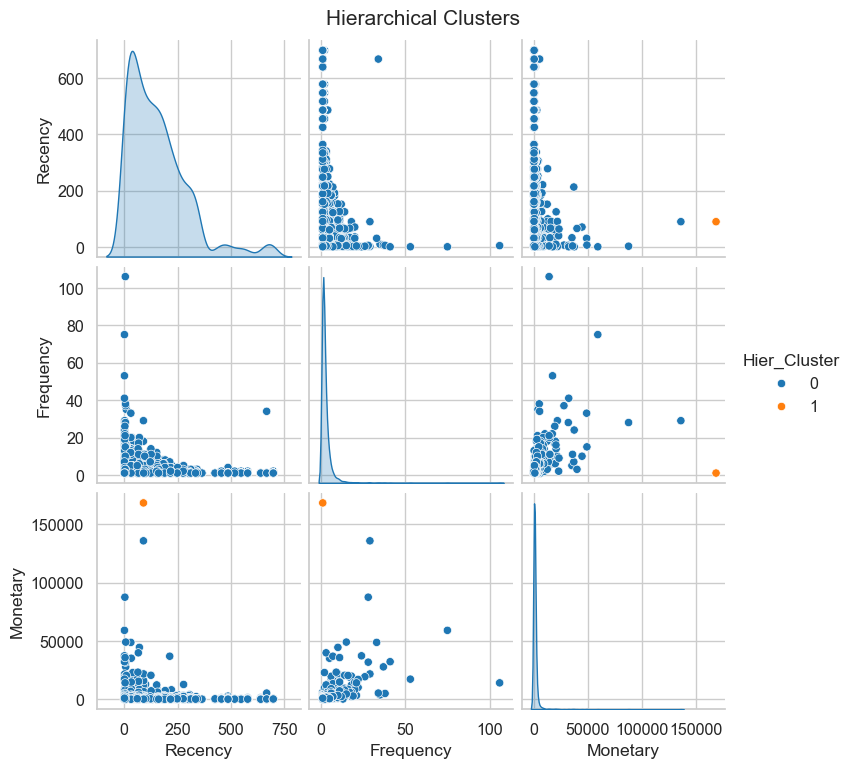

In [24]:
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="Hier_Cluster", palette="tab10")
plt.suptitle("Hierarchical Clusters", y=1.02)
plt.show()

Cluster 2 (Recency=4, Freq=2, Monetary=680) → Recent low spenders.

Cluster 3 (Recency=4, Freq=5.7, Monetary=2071) → Recent, frequent, high spenders (VIP).

Cluster 4 (Recency=152, Freq=2, Monetary=707) → Older moderate spenders.

Cluster 5 (Recency=4, Freq=1, Monetary=359) → Recent one-time buyers.

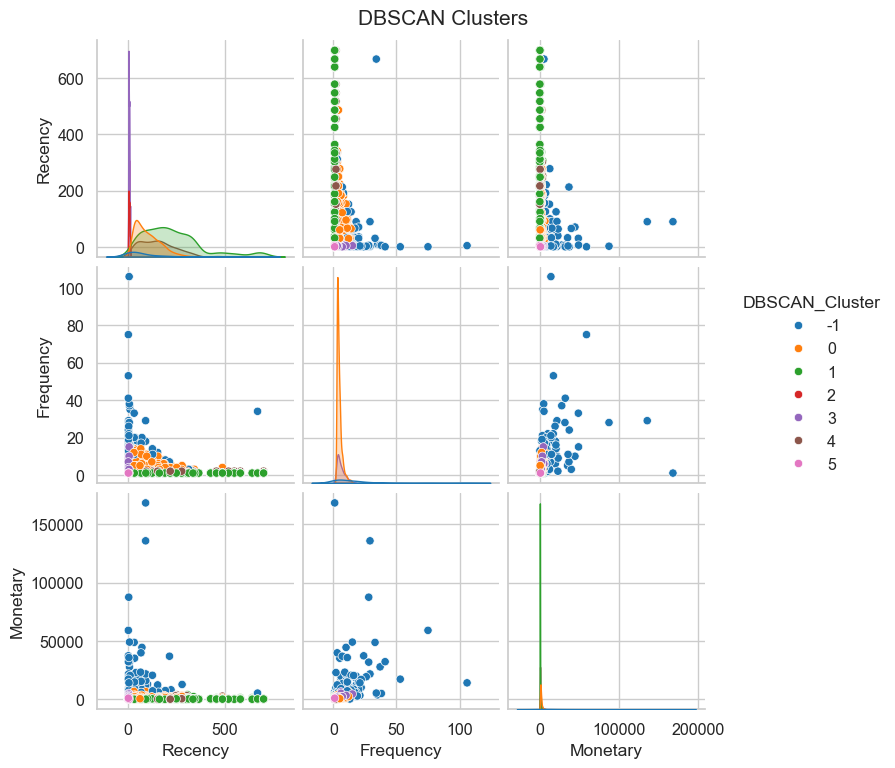

In [25]:
sns.pairplot(rfm, vars=["Recency", "Frequency", "Monetary"], hue="DBSCAN_Cluster", palette="tab10")
plt.suptitle("DBSCAN Clusters", y=1.02)
plt.show()

In [27]:
from sklearn.metrics import adjusted_rand_score

In [28]:
sil_kmeans = silhouette_score(rfm_scaled, rfm["KMeans_Cluster"])
sil_hier = silhouette_score(rfm_scaled, rfm["Hier_Cluster"])
sil_db = silhouette_score(rfm_scaled, rfm["DBSCAN_Cluster"]) if len(set(rfm["DBSCAN_Cluster"])) > 1 else -1

print(f"KMeans Silhouette Score: {sil_kmeans:.3f}")
print(f"Hierarchical Silhouette Score: {sil_hier:.3f}")
print(f"DBSCAN Silhouette Score: {sil_db:.3f}")

KMeans Silhouette Score: 0.439
Hierarchical Silhouette Score: 0.592
DBSCAN Silhouette Score: 0.225


In [29]:
ari_kmeans_hier = adjusted_rand_score(rfm["KMeans_Cluster"], rfm["Hier_Cluster"])
ari_kmeans_db = adjusted_rand_score(rfm["KMeans_Cluster"], rfm["DBSCAN_Cluster"])
ari_hier_db = adjusted_rand_score(rfm["Hier_Cluster"], rfm["DBSCAN_Cluster"])

print("\nAdjusted Rand Index (ARI):")
print(f"KMeans vs Hierarchical: {ari_kmeans_hier:.3f}")
print(f"KMeans vs DBSCAN: {ari_kmeans_db:.3f}")
print(f"Hierarchical vs DBSCAN: {ari_hier_db:.3f}")


Adjusted Rand Index (ARI):
KMeans vs Hierarchical: 0.001
KMeans vs DBSCAN: 0.393
Hierarchical vs DBSCAN: 0.000


In [30]:
def summarize_clusters(df, cluster_col):
    return df.groupby(cluster_col)[["Recency", "Frequency", "Monetary"]].mean().round(2)

print("\n🔹 KMeans Cluster Summary:")
print(summarize_clusters(rfm, "KMeans_Cluster"))

print("\n🔹 Hierarchical Cluster Summary:")
print(summarize_clusters(rfm, "Hier_Cluster"))

print("\n🔹 DBSCAN Cluster Summary (excluding noise):")
if -1 in rfm["DBSCAN_Cluster"].unique():
    print(summarize_clusters(rfm[rfm["DBSCAN_Cluster"] != -1], "DBSCAN_Cluster"))
else:
    print(summarize_clusters(rfm, "DBSCAN_Cluster"))


🔹 KMeans Cluster Summary:
                Recency  Frequency  Monetary
KMeans_Cluster                              
0                 58.10       5.51   3228.52
1                199.16       1.37    422.33

🔹 Hierarchical Cluster Summary:
              Recency  Frequency   Monetary
Hier_Cluster                               
0              155.41       2.66    1237.32
1               90.00       1.00  168469.60

🔹 DBSCAN Cluster Summary (excluding noise):
                Recency  Frequency  Monetary
DBSCAN_Cluster                              
0                 99.88       4.44   1515.55
1                226.25       1.00    349.58
2                  4.42       2.00    679.86
3                  4.18       5.74   2071.39
4                152.73       2.00    706.76
5                  4.55       1.00    358.71


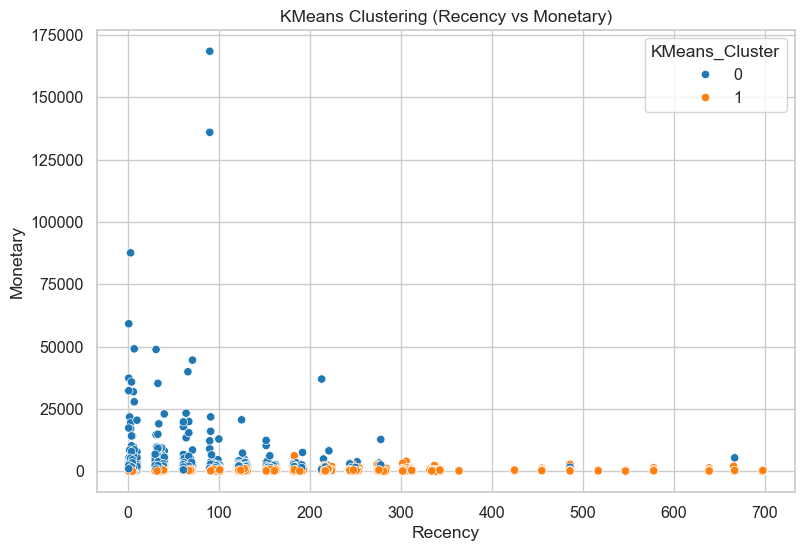

In [31]:
# KMeans
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="KMeans_Cluster", palette="tab10")
plt.title("KMeans Clustering (Recency vs Monetary)")
plt.show()

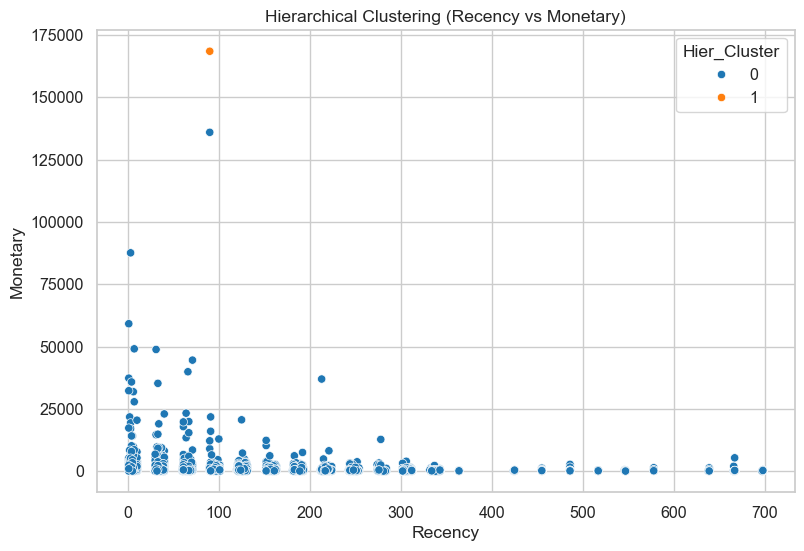

In [32]:
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Hier_Cluster", palette="tab10")
plt.title("Hierarchical Clustering (Recency vs Monetary)")
plt.show()

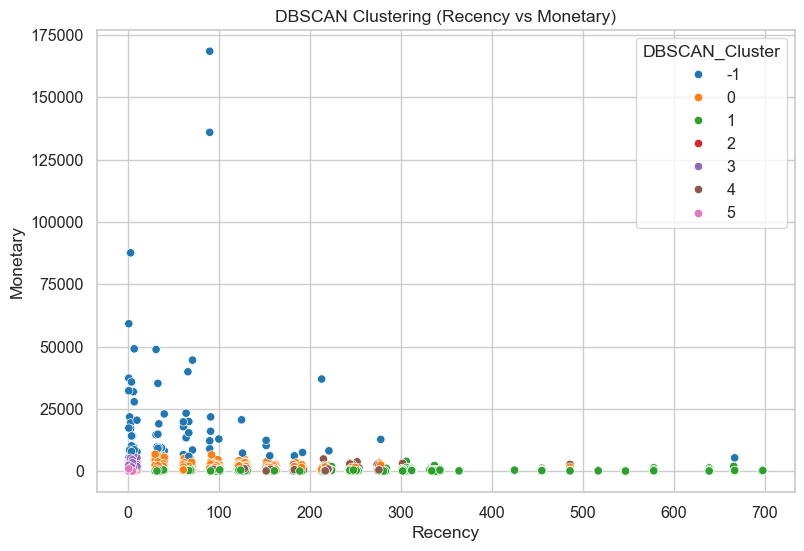

In [33]:
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="DBSCAN_Cluster", palette="tab10")
plt.title("DBSCAN Clustering (Recency vs Monetary)")
plt.show()